Enter a stock name to analyze or Enter 1 to use sample provided : googl
Fetching Data... finished               OGL\
Fetching Data from yahoo finance for :GOOGL|

var: -0.0608
cvar: -0.1128


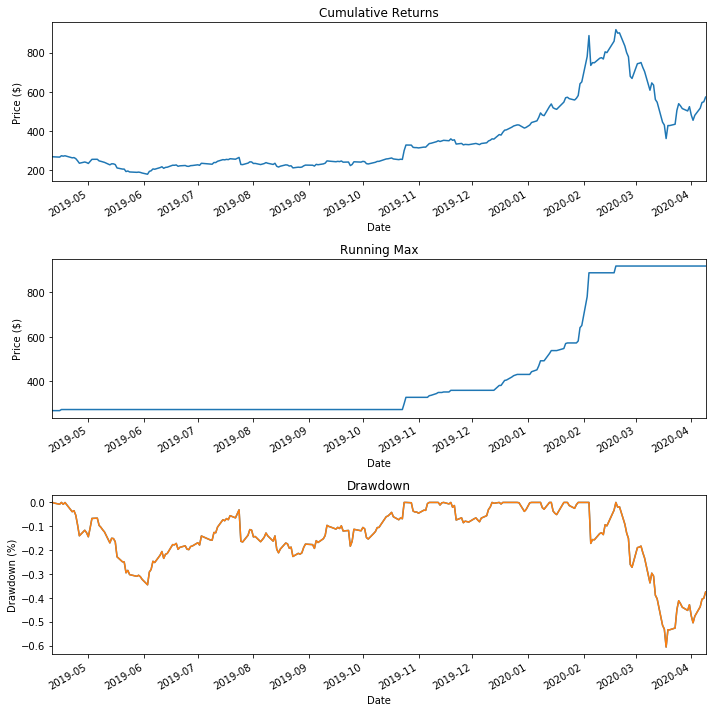

var: -0.0746
cvar: -0.1322


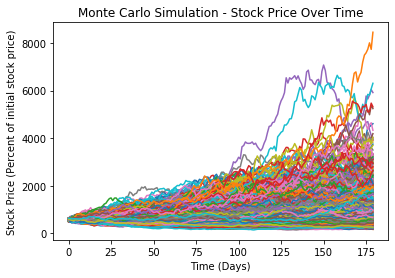

Monte Carlo var: -0.0644


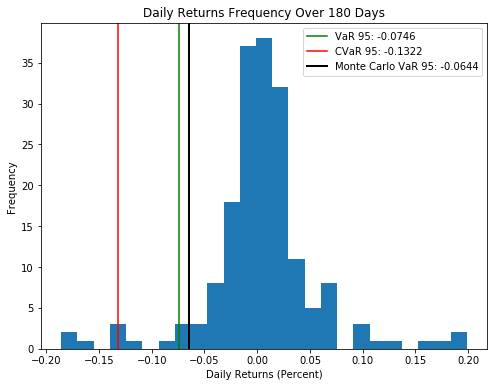

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import DataReader
from datetime import datetime
import sys, time, threading
#------ Input taken from user of a Stock name enlisted in stock markets------#
#------ if user wants to test the project a sample file is also provided-----#
stock=input(("Enter a stock name to analyze or Enter 1 to use sample provided : "))
end = datetime.now()
start = datetime(end.year-1,end.month,end.day)
#------ fetchdata() is used to fetch data from yahoo finance------#
#------ data fetched is stock history of past 1 year-----#
def fetchdata():
    data1 = DataReader(stock.upper(),'yahoo',start,end)
    data1.to_csv(stock+'.csv')
    file_name=stock+".csv"
    time.sleep(.1)
    sys.stdout.write('\r'+'Fetching Data... finished               \n')
    sys.stdout.flush()
#------ loading() is used to visualize animation till fetchdata() downloads data----#
def loading():
    chars = "/—\|"
    for char in chars:
        sys.stdout.write('\r'+'Fetching Data from yahoo finance for :'+stock.upper()+char)
        time.sleep(.1)
        sys.stdout.flush() 
if(stock=='1'):
    file_name='sample.csv'
else:
    fetchdatathread = threading.Thread(name='Fetching Data', target=fetchdata)
    fetchdatathread.start()
    while fetchdatathread.isAlive():
                loading()
    print("\n")
#----- fetched data is stored in csv file fomat and then is procesed-----#
data = pd.read_csv(file_name, parse_dates=['Date']) 
data = data.sort_values(by='Date')
data.set_index('Date', inplace=True)
data['Returns'] = data['Adj Close'].pct_change()  #------ Create daily returns column-----#
returns = data['Returns'].dropna()  #----- Removing any null values -----#


avg_daily_return = np.mean(returns)  #------ calculating mean of daily returns------#
std_dev = np.std(returns)  #------ calculating standard deviation of daily returns-----#

#------Calculating VaR(value at risk) 95 and CVaR(conditional value at risk) 95
var95 = np.percentile(returns, 5)
print('var: %0.4f' % var95)
cvar95 = returns[returns <= var95].mean()
print('cvar: %0.4f' % cvar95)

#---- Calculating drawdown------#
cum_rets_dollars = data['Adj Close']
running_max = cum_rets_dollars.cummax()
drawdown = (cum_rets_dollars) / running_max - 1

#------ Plot drawdown-----#
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Price ($)')
cum_rets_dollars.plot()
plt.tight_layout()

plt.subplot(3,1,2)
plt.title('Running Max')
plt.xlabel('Date')
plt.ylabel('Price ($)')
running_max.plot()

plt.subplot(3,1,3)
drawdown.plot()
plt.title('Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
drawdown.plot()
plt.tight_layout()
plt.show()

#---- Defining constraints -----#
T = 180  #---Time period---#
S0 = cum_rets_dollars.iloc[-1]  #--- recent stock price---#
NUM_SIM = 1000  #--- Number of Monte Carlo simulations ---#

#--- Re-calculation VaR and CVaR using only data from the most recent T days ---#
returns_comp = returns.tail(T)
var95 = np.percentile(returns_comp, 5)
print('var: %0.4f' % var95)
cvar95 = returns_comp[returns_comp <= var95].mean()
print('cvar: %0.4f' % cvar95)

#---Monte Carlo simulation---#
for i in range(NUM_SIM):
    rand_rets = np.random.normal(avg_daily_return, std_dev, T)  #---Generate a random daily stock return using the stock's historical statistical data

    #--- Creating cumulative returns data ---#
    cum_rets = rand_rets + 1
    forecast = S0 * (cum_rets.cumprod())

    #--- Plot the Monte Carlo simulations over time --#
    plt.plot(forecast)
    plt.title('Monte Carlo Simulation - Stock Price Over Time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Stock Price (Percent of initial stock price)')
plt.show()

#--- Calculate Monte Carlo VaR from the simulations ---#
var = np.percentile(rand_rets, 5)
print('Monte Carlo var: %0.4f' % var)

#--- Create a histogram of daily stock returns ---#
plt.figure(figsize=(8,6))
plt.hist(returns_comp, bins=25)
plt.title('Daily Returns Frequency Over %d Days' % T)
plt.xlabel('Daily Returns (Percent)')
plt.ylabel('Frequency')
plt.axvline(x=var95, color='green', label='VaR 95: %0.4f' % var95)  # plot the historical VaR on the histogram
plt.axvline(x=cvar95, color='red', label='CVaR 95: %0.4f' % cvar95)  # plot the historical CVar on the histogram
plt.axvline(x=var, color='black', linewidth=2, label='Monte Carlo VaR 95: %0.4f' % var)  # plot the Monte Carlo VaR on the histogram
plt.legend()
plt.show()
